<a href="https://colab.research.google.com/github/vasist1987/HackerRank_Python/blob/master/GRU_Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-01-27 08:24:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-27 08:24:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-27 08:24:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import zipfile
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from tqdm import tqdm
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score, precision_score, recall_score

from tensorflow import keras
from keras.layers import Input
from keras import Model
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import Callback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

class dataImports():
    
    def __init__(self, df=None):
        self.df = df
        
    def openZipFileCsv(self,zipPath,fileName):
        zp=zipfile.ZipFile(zipPath,'r')
        self.df= pd.read_csv(zp.open(fileName))
        return self
        
    def import_Data_File(self,objectName,src_type,sheet=None):   
        if src_type=='csv':
            self.df=pd.read_csv(objectName)       
        if src_type=='excel':
            self.df=pd.read_excel(objectName, sheet_name = None)
        return self
    def import_Data_Database(self,src_type,tbname,server_name,db_name,uname,pwd):
        if src_type=='mssql':
            con=getConnectionMSSQL(server_name,db_name,uname,pwd)
            self.df=selectFromDb(tbname,server_name,db_name,uname,pwd,con)
        return self
    
        
    def describe(self):              
        print('------------------------------------DF Head-----------------------------------------')
        print(self.df.head())
        print('-------------------------------------Shape------------------------------------------')
        print(self.df.shape)
        print('--------------------------------------Info------------------------------------------')
        print(self.df.info())
        print('------------------------------DataSet Description-----------------------------------')
        print(self.df.describe())
        return self


def importData(train_loc,train_file,test_loc,test_file,LowerCase):
    df_train=(dataImports().openZipFileCsv(train_loc,train_file)).df
    
    df_test=(dataImports().openZipFileCsv(test_loc,test_file)).df
    print()
    if(LowerCase):
        df_train=dataLowerCase(df_train,"train Set")
        df_test=dataLowerCase(df_test,"test Set")
    return df_train,df_test

def dataLowerCase(DataFram,dataFrameName):
    print("Invoking lower casing")
    #timeLogger("Start Time LowerCasing " +dataFrameName)
    result = DataFram.apply(lambda x: x.astype(str).str.lower()).apply(lambda x: x.astype(str).str.encode('ascii', 'ignore').str.decode('ascii'))
    #timeLogger("End Time LowerCasing "+dataFrameName)
    return result

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
df_train,df_test=importData('/content/drive/MyDrive/LJMU Masters/code/train.csv.zip','train.csv','/content/drive/MyDrive/LJMU Masters/code/test.csv.zip','test.csv',True)


Invoking lower casing
Invoking lower casing


In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 300  

In [ ]:

MAX_FEATURES = 166289
MAX_WORDS = MAX_SEQUENCE_LENGTH

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(df_train[['question1','question2']], df_train['is_duplicate'], test_size = 0.30, stratify=df_train['is_duplicate'])

In [ ]:
y_train = y_train.values
y_test = y_test.values
X_train_text1 = X_train['question1'].values
X_train_text2 = X_train['question2'].values
X_test_text1 = X_test['question1'].values
X_test_text2 = X_test['question2'].values
# X_val_text = df_test['question_text'].values
#X_test_text = df_test['clean_question'].values
print(X_train_text1.shape,X_train_text1.shape,y_train.shape)
#print(X_test_text.shape)

(283003,) (283003,) (283003,)


In [ ]:

from scipy.sparse import hstack
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_train_text1+X_train_text2))
X_train1 = tokenizer.texts_to_sequences(X_train_text1)
X_train2 = tokenizer.texts_to_sequences(X_train_text2)

X_test1 = tokenizer.texts_to_sequences(X_test_text1)
X_test2 = tokenizer.texts_to_sequences(X_test_text2)
# X_val = tokenizer.texts_to_sequences(X_val_text)
#X_test = tokenizer.texts_to_sequences(X_test_text)

In [ ]:
X_train1 = sequence.pad_sequences(X_train1, maxlen=MAX_WORDS)
X_train2 = sequence.pad_sequences(X_train2, maxlen=MAX_WORDS)
X_test1 = sequence.pad_sequences(X_test1, maxlen=MAX_WORDS)
X_test2 = sequence.pad_sequences(X_test2, maxlen=MAX_WORDS)
# X_test = sequence.pad_sequences(X_val, maxlen=MAX_WORDS)
#X_test = sequence.pad_sequences(X_test, maxlen=MAX_WORDS)
print(X_train1.shape,X_train2.shape)

(283003, 100) (283003, 100)


In [ ]:

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [ ]:
gloveEmbed = get_embed_mat('glove.6B.300d.txt', MAX_FEATURES, 300)

Found 400000 word vectors.


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
word_index = tokenizer.word_index
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[gloveEmbed],
                            input_length=MAX_WORDS,
                            trainable=False)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(300, return_sequences = True)))
model.add(Bidirectional(GRU(300, return_sequences = True)))
model.add(Dropout(0.1))
model.add(Bidirectional(GRU(300, return_sequences = True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics =['accuracy',f1_m,precision_m, recall_m])
print(model.summary())
file='/content/drive/MyDrive/LJMU Masters/code/glove_01.png'

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          23771400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 600)          1083600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 600)          1623600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 600)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 600)          1623600   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [ ]:
y_train = y_train.astype(np.float)
model.fit([X_train1,X_train2], y_train,
          epochs=10, batch_size=128, verbose=1)

Epoch 1/10
2211/2211 [==============================] - 351s 159ms/step - loss: 0.5651 - accuracy: 0.7096 - f1_m: 0.5167 - precision_m: 0.6612 - recall_m: 0.4395
Epoch 2/10
2211/2211 [==============================] - 352s 159ms/step - loss: 0.5273 - accuracy: 0.7388 - f1_m: 0.5893 - precision_m: 0.7000 - recall_m: 0.5169
Epoch 3/10
2211/2211 [==============================] - 352s 159ms/step - loss: 0.5061 - accuracy: 0.7534 - f1_m: 0.6179 - precision_m: 0.7193 - recall_m: 0.5489
Epoch 4/10
2211/2211 [==============================] - 352s 159ms/step - loss: 0.4885 - accuracy: 0.7652 - f1_m: 0.6416 - precision_m: 0.7317 - recall_m: 0.5780
Epoch 5/10
2211/2211 [==============================] - 352s 159ms/step - loss: 0.4698 - accuracy: 0.7766 - f1_m: 0.6630 - precision_m: 0.7448 - recall_m: 0.6038
Epoch 6/10
2211/2211 [==============================] - 352s 159ms/step - loss: 0.4508 - accuracy: 0.7882 - f1_m: 0.6845 - precision_m: 0.7570 - recall_m: 0.6308
Epoch 7/10
2211/2211 [======

In [ ]:
preds = model.predict(X_test1, batch_size = 128, verbose = 1)

948/948 [==============================] - 34s 35ms/step


In [ ]:
def line_search_f1_score(y_score, y_test):
    max_f1_score = 0
    opt_threshold = 0
    for threshold in [i*0.01 for i in range(100)]:
        y_preds = y_score > threshold
        score = f1_score(y_preds, y_test)
        if max_f1_score < score:
            max_f1_score = score
            opt_threshold = threshold
    return max_f1_score, opt_threshold

In [ ]:
y_test1 = y_test.astype(np.float)
max_f1_score, threshold = line_search_f1_score(preds, y_test1)

In [ ]:
print(max_f1_score,threshold)

0.6836663049722347 0.38


In [ ]:
predictions = [1 if x>0.38 else 0 for x in preds]
print(accuracy_score(predictions, y_test1))
print(f1_score(predictions, y_test1))

0.7548294541047268
0.6836663049722347


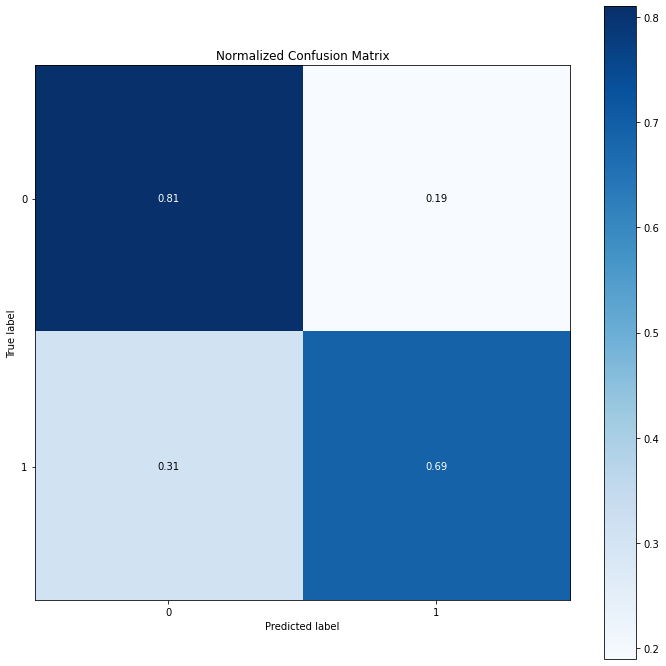

In [ ]:
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(predictions, y_test1,figsize=(12,12), normalize='all')

In [ ]:
cf_matrix = confusion_matrix(predictions, y_test1)

import seaborn as sns
# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
                # cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
# labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
#           zip(group_names,group_counts,group_percentages)]
labels = [f'{v1}' for v1 in zip(group_percentages)]

# labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
# sns.heatmap(cf_matrix, annot=False, fmt='', cmap='Blues')

print(accuracy_score(predictions, y_test1))

ValueError: ignored

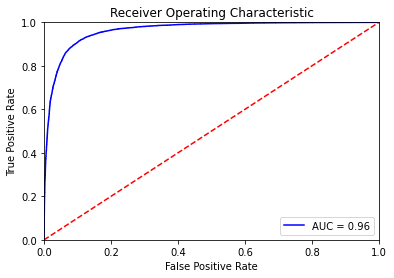

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


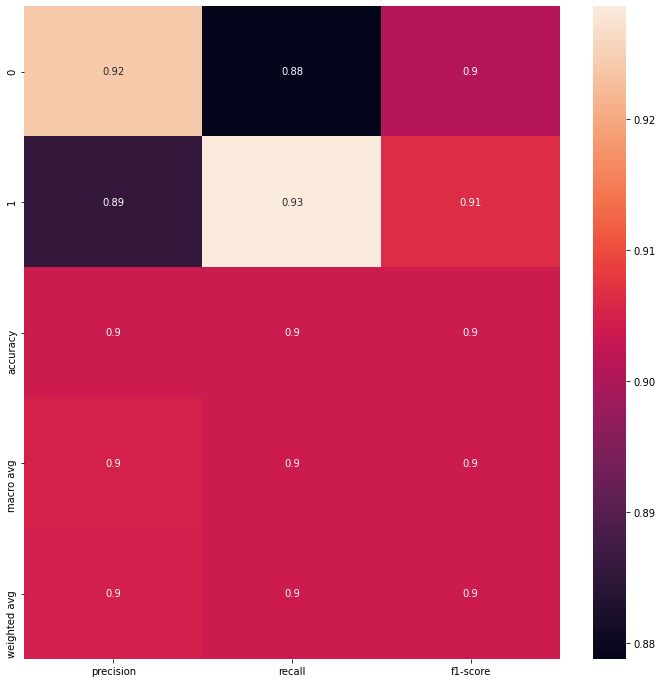

In [ ]:
from sklearn.metrics import classification_report

clf_report = classification_report(y_test,
                                   predictions,
                                   labels=[0,1],
                                   output_dict=True)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax,square = False)